In [28]:
%%capture
%pip install nltk
%pip install scipy
%pip install wordcloud
%pip install 


In [ ]:
%%capture
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import string
import warnings
from scipy.stats import pearsonr 
from nltk.corpus import stopwords
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


nltk.download('stopwords')
warnings.filterwarnings('ignore')

In [30]:
ls

 Volume in drive D is DATA
 Volume Serial Number is FC9C-ABB3

 Directory of d:\Akshat\projects_24'\EchoSense

08-03-2025  05:07 PM    <DIR>          .
06-03-2025  04:05 PM    <DIR>          ..
07-03-2025  07:28 PM    <DIR>          .vscode
08-03-2025  05:18 PM            48,738 EchoMind.ipynb
08-03-2025  05:07 PM                36 README.md
07-03-2025  07:28 PM         2,415,748 tedx_dataset.csv
               3 File(s)      2,464,522 bytes
               3 Dir(s)  429,487,955,968 bytes free


In [31]:
df = pd.read_csv('tedx_dataset.csv')
print(df.head())
df.shape


                                idx       main_speaker  \
0  8d2005ec35280deb6a438dc87b225f89     Alexandra Auer   
1  b3072cd11f40eb57fd259555264476c6  Elizabeth Gilbert   
2  4adc9fee977fa04c357ed4c9b52aa3cc       Butterscotch   
3  59c641a72b495d522a7932145d6c02b3         Ethan Lisi   
4  d227f2faf6ec185e54436d86463f499b      Daniel Finkel   

                                               title  \
0                    The intangible effects of walls   
1  It's OK to feel overwhelmed. Here's what to do...   
2                                  "Accept Who I Am"   
3               What it's really like to have autism   
4              Can you solve the sea monster riddle?   

                                             details           posted  \
0  More barriers exist now than at the end of Wor...  Posted Apr 2020   
1  If you're feeling anxious or fearful during th...  Posted Apr 2020   
2  Firing off her formidable beatboxing skills, m...  Posted Apr 2020   
3  "Autism is not a di

(4467, 7)

In [32]:
print(df.columns)
df.isnull().sum()

Index(['idx', 'main_speaker', 'title', 'details', 'posted', 'url',
       'num_views'],
      dtype='object')


idx                0
main_speaker       1
title              0
details            0
posted             0
url                0
num_views       4258
dtype: int64

In [33]:
#drop num_views as mosst data missing
df = df.drop('num_views', axis=1)


In [34]:
splitted = df['posted'].str.split(' ', expand=True)

#create col for month and year for the talks
df['year'] = splitted[2].astype('int')
df['month'] = splitted[1]


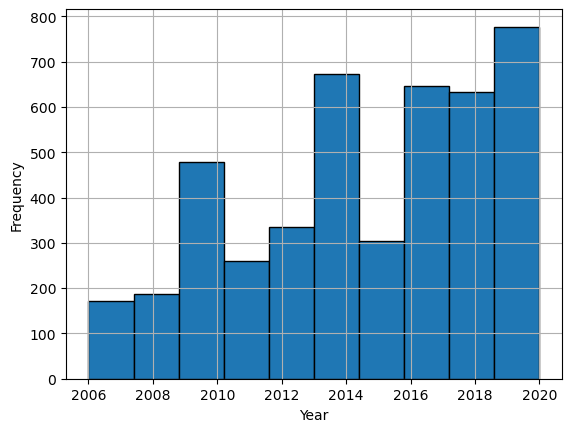

In [35]:
df['year'].hist(bins=10, edgecolor='black')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.show()




In [36]:
print(df.columns)


Index(['idx', 'main_speaker', 'title', 'details', 'posted', 'url', 'year',
       'month'],
      dtype='object')


In [37]:
# Let's combine the title and the details of the talk.
df['details'] = df['title'] + ' ' + df['details']

# Removing the unnecessary information
df = df[['main_speaker', 'details']]
df.dropna(inplace = True)
df.head()


,main_speaker,details
0,Alexandra Auer,The intangible effects of walls More barriers ...
1,Elizabeth Gilbert,It's OK to feel overwhelmed. Here's what to do...
2,Butterscotch,"""Accept Who I Am"" Firing off her formidable be..."
3,Ethan Lisi,"What it's really like to have autism ""Autism i..."
4,Daniel Finkel,Can you solve the sea monster riddle? Accordin...


In [38]:
df.copy()

,main_speaker,details
0,Alexandra Auer,The intangible effects of walls More barriers ...
1,Elizabeth Gilbert,It's OK to feel overwhelmed. Here's what to do...
2,Butterscotch,"""Accept Who I Am"" Firing off her formidable be..."
3,Ethan Lisi,"What it's really like to have autism ""Autism i..."
4,Daniel Finkel,Can you solve the sea monster riddle? Accordin...
...,...,...
4462,Hans Rosling,The best stats you've ever seen You've never s...
4463,Sir Ken Robinson,Do schools kill creativity? Sir Ken Robinson m...
4464,Majora Carter,Greening the ghetto In an emotionally charged ...
4465,David Pogue,Simplicity sells New York Times columnist Davi...


In [39]:
nltk.download('stopwords')

True

In [40]:
#text_processging
def remove_stopwords(text):
    stop_words = stopwords.words('english')

    imp_words = []

    for word in str(text).split():
        word = word.lower()

        if word not in stop_words:
            imp_words.append(word)
    
    output = " ".join(imp_words)

    return output
    

In [41]:
def clean_text(text):
    return remove_stopwords(text)

df['details'] = df['details'].apply(clean_text)

df.head()

,main_speaker,details
0,Alexandra Auer,intangible effects walls barriers exist end wo...
1,Elizabeth Gilbert,ok feel overwhelmed. here's next feeling anxio...
2,Butterscotch,"""accept am"" firing formidable beatboxing skill..."
3,Ethan Lisi,"really like autism ""autism disease; another wa..."
4,Daniel Finkel,"solve sea monster riddle? according legend, ev..."


In [42]:
#removing all the punctuations
import re

def cleaning_punctuations(text):
    return re.sub(r'[^\w\s]', '', text)  

df['details'] = df['details'].apply(cleaning_punctuations)

df.head()


,main_speaker,details
0,Alexandra Auer,intangible effects walls barriers exist end wo...
1,Elizabeth Gilbert,ok feel overwhelmed heres next feeling anxious...
2,Butterscotch,accept am firing formidable beatboxing skills ...
3,Ethan Lisi,really like autism autism disease another way ...
4,Daniel Finkel,solve sea monster riddle according legend ever...


In [47]:

#building our recommender system
#using TF-IDF vectorixer to convert text-->num


vectorizer = TfidfVectorizer(analyzer='word')
vectorizer.fit(df['details'])


TfidfVectorizer()

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()  # Ensure vectorizer is initialized


def get_similarities(talk_content, data=df):

    vectorizer.fit(df['details'])
    # Getting vector for the input talk_content.
    talk_array1 = vectorizer.transform(talk_content).toarray()

    # We will store similarity for each row of the dataset.
    sim = []
    pea = []
    for idx, row in data.iterrows():
        details = row['details']

        # Getting vector for current talk.
        talk_array2 = vectorizer.transform(
            data[data['details'] == details]['details']).toarray()

        # Calculating cosine similarities
        cos_sim = cosine_similarity(talk_array1, talk_array2)[0][0]

        # Calculating pearson correlation
        pea_sim = pearsonr(talk_array1.squeeze(), talk_array2.squeeze())[0]

        sim.append(cos_sim)
        pea.append(pea_sim)

    return sim, pea

print(type(df))  


<class 'pandas.core.frame.DataFrame'>


In [49]:
def recommend_talks(talk_content, data=df):

    df['cos_sim'], data['pea_sim'] = get_similarities(talk_content)

    df.sort_values(by=['cos_sim', 'pea_sim'], ascending=[
                     False, False], inplace=True)

    display(df[['main_speaker', 'details']].head())


In [51]:
talk_content = ['Climate change and impact on the health\
. How can we change this world by reducing carbon footprints?']
recommend_talks(talk_content)


,main_speaker,details
582,Sarvesh Subramanian,app predicts impact global climate change deep...
3302,James Hansen,must speak climate change top climate scientis...
377,Britt Wray,climate change affects mental health for thats...
2586,Gavin Schmidt,emergent patterns climate change cant understa...
562,Joanne Chory,supercharged plants could slow climate change ...
